In [98]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


Collect data for Eurojackpot spanning 12 years through web scraping.

In [199]:
# give year information as a list

year_list = [2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]
date_list = []

# Retrieve all dates for each year using the URL and append them to a list
for year in year_list:    
    url = 'https://www.lottonumbers.com/eurojackpot-results-' + str(year)
    response = requests.get(url)
    soup = BeautifulSoup(response.content)
    date_box = soup.find('table', attrs= {'class':'lotteryTable'}).find('tbody').find_all('a')
    for date in date_box:
        date_list.append(date.get('href').split('/')[3])
# print(date_list)
        
# Retrieve 'Balls' information using URL
jackpot_df = pd.DataFrame()
for date in date_list:
    url = 'https://www.lottonumbers.com/eurojackpot/results/' + date
    response = requests.get(url)
    soup = BeautifulSoup(response.content)
    balls = [li.text.strip().split()[0] for li in soup.find('ul', attrs={'class':"balls -lg -cn"}).find_all('li')]
    # print(balls)

    #Retrieve 'Prize Tier', 'Per Winner Prize', 'Total Winners' information using table in soup, and append into df
    prize_breakdown = soup.find('table', attrs= {'class':"table-breakdown"})
    draw_df =  pd.read_html(str(prize_breakdown))[0]
    #Append 'Balls' and 'Date' information into df
    draw_df['Balls'] = str(','.join(balls))
    draw_df['Date'] = date
    # print(draw_df.head())

    ###DATA CLEANING
    #remove rows where ['Prize Tier'] = 'Totals'
    draw_df = draw_df[draw_df['Prize Tier'] != 'Totals']

    #clean Prize Tier column
    draw_df['Prize Tier'] = draw_df['Prize Tier'].apply(lambda x: '+'.join([n if n.isdigit() else '0' for n in x.split()[1:] if n.isdigit()]) if 'and' in x else f'{x.split()[1]}+0')
    
    #concat two dataframes in jackpot_df
    jackpot_df = pd.concat([jackpot_df, draw_df], ignore_index=True)
jackpot_df.head()

,Prize Tier,Per Winner Prize,Total Winners,Balls,Date
0,5+2,"€21,000,000.00",Rollover 0,"5,8,22,32,39,7,8",2012-12-28
1,5+1,"€246,863.80",3,"5,8,22,32,39,7,8",2012-12-28
2,5+0,"€24,205.20",4,"5,8,22,32,39,7,8",2012-12-28
3,4+2,"€6,874.80",13,"5,8,22,32,39,7,8",2012-12-28
4,4+1,€190.10,372,"5,8,22,32,39,7,8",2012-12-28


In [203]:
# Export the data to both a CSV and an Excel file
jackpot_df.to_csv('Eurojackpot.csv')
jackpot_df.to_excel('Eurojackpot.xlsx')

Data Cleaning

In [2]:
jackpot_df = pd.read_excel('Eurojackpot.xlsx')
jackpot_df.dtypes

Unnamed: 0           int64
Prize Tier          object
Per Winner Prize    object
Total Winners       object
Balls               object
Date                object
dtype: object

In [23]:
# change data types
jackpot_df['Per Winner Prize'] = jackpot_df['Per Winner Prize'].str.replace('[^0-9.]', '', regex=True).astype(float)
jackpot_df['Date'] = jackpot_df['Date'].astype('datetime64')
jackpot_df['Total Winners'] = jackpot_df['Total Winners'].str.replace('[^0-9.]', '', regex=True).fillna(0).astype('int')
jackpot_df.dtypes

Unnamed: 0                   int64
Prize Tier                  object
Per Winner Prize           float64
Total Winners                int64
Balls                       object
Date                datetime64[ns]
dtype: object

In [24]:
jackpot_df.head(10)

,Unnamed: 0,Prize Tier,Per Winner Prize,Total Winners,Balls,Date
0,0,5+2,21000000.0,0,"5,8,22,32,39,7,8",2012-12-28
1,1,5+1,246863.8,3,"5,8,22,32,39,7,8",2012-12-28
2,2,5+0,24205.2,4,"5,8,22,32,39,7,8",2012-12-28
3,3,4+2,6874.8,13,"5,8,22,32,39,7,8",2012-12-28
4,4,4+1,190.1,372,"5,8,22,32,39,7,8",2012-12-28
5,5,4+0,96.9,461,"5,8,22,32,39,7,8",2012-12-28
6,6,3+2,69.7,908,"5,8,22,32,39,7,8",2012-12-28
7,7,3+1,18.1,16805,"5,8,22,32,39,7,8",2012-12-28
8,8,2+2,17.9,14332,"5,8,22,32,39,7,8",2012-12-28
9,9,3+0,14.0,19093,"5,8,22,32,39,7,8",2012-12-28


In [27]:
jackpot_df.to_excel('Eurojackpot.xlsx')
jackpot_df = jackpot_df.sort_values(by='Date')

In [28]:
# calculate total_reward and total_deposit and append into a df
total_reward = jackpot_df[jackpot_df['Prize Tier'] == '2+1']
total_reward['Total Reward'] = total_reward.apply(lambda row: (row['Per Winner Prize']) * (row['Total Winners']) * (100/20.3), axis=1)
total_reward['Total Deposit'] = total_reward['Total Reward'] * 2

# # Optional: Format 'Total Reward' , 'Total Deposit'columns with commas
total_reward['Total Reward'] = total_reward['Total Reward']
total_reward['Total Deposit'] = total_reward['Total Deposit']

total_reward = total_reward.drop(columns='Unnamed: 0')
total_reward.tail()
# total_reward.dtypes


/var/folders/4v/r9p762h55mn0ttvynz3ppd440000gn/T/ipykernel_89848/594884052.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_reward['Total Reward'] = total_reward.apply(lambda row: (row['Per Winner Prize']) * (row['Total Winners']) * (100/20.3), axis=1)
/var/folders/4v/r9p762h55mn0ttvynz3ppd440000gn/T/ipykernel_89848/594884052.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_reward['Total Deposit'] = total_reward['Total Reward'] * 2
/var/folders/4v/r9p762h55mn0ttvynz3ppd440000gn/T/ipykernel

,Prize Tier,Per Winner Prize,Total Winners,Balls,Date,Total Reward,Total Deposit
7247,2+1,10.6,711460,"2,21,34,40,48,2,6",2023-12-29,3.715013e+07,7.430026e+07
8531,2+1,11.1,527283,"19,26,36,48,49,10,11",2024-01-02,2.883173e+07,5.766346e+07
8519,2+1,10.6,894780,"11,30,32,45,47,3,10",2024-01-05,4.672250e+07,9.344500e+07
8507,2+1,9.9,743261,"9,12,26,41,47,7,10",2024-01-09,3.624770e+07,7.249541e+07
8495,2+1,10.3,957645,"3,31,34,43,45,6,9",2024-01-12,4.858987e+07,9.717974e+07


In [29]:
# Export the data to an Excel file
total_reward.to_excel('total_reward.xlsx')

In [30]:
# Find all big_reward data and export it to an Excel file
big_reward = jackpot_df[jackpot_df['Prize Tier'] == '5+2']
big_reward.to_excel('big_reward.xlsx')


In [32]:
# Calculate potential profit by giving winning probabilities for each tier and append it to jackpot_df
winning_probabilities = {
    '5+2': 1/139838160,
    '5+1': 1/6991908,
    '5+0': 1/3107515,
    '4+2': 1/621503,
    '4+1': 1/31075,
    '4+0': 1/13811,
    '3+2': 1/14125,
    '3+1': 1/706,
    '3+0': 1/314,
    '2+2': 1/985,
    '2+1': 1/49,
    '1+2': 1/188
}

jackpot_df['potential_profit'] = jackpot_df.apply(lambda row: row['Per Winner Prize'] * winning_probabilities[row['Prize Tier']], axis=1)

jackpot_df.tail(10)

,Unnamed: 0,Prize Tier,Per Winner Prize,Total Winners,Balls,Date,potential_profit
8486,8486,5+0,295917.5,8,"3,31,34,43,45,6,9",2024-01-12,0.095226
8487,8487,4+2,4881.1,80,"3,31,34,43,45,6,9",2024-01-12,0.007854
8492,8492,3+1,21.6,64176,"3,31,34,43,45,6,9",2024-01-12,0.030595
8489,8489,3+2,157.2,3415,"3,31,34,43,45,6,9",2024-01-12,0.011129
8490,8490,4+0,129.7,3009,"3,31,34,43,45,6,9",2024-01-12,0.009391
8491,8491,2+2,23.0,53914,"3,31,34,43,45,6,9",2024-01-12,0.023350
8494,8494,1+2,11.1,296037,"3,31,34,43,45,6,9",2024-01-12,0.059043
8493,8493,3+0,18.9,138941,"3,31,34,43,45,6,9",2024-01-12,0.060191
8488,8488,4+1,355.7,1372,"3,31,34,43,45,6,9",2024-01-12,0.011447
8495,8495,2+1,10.3,957645,"3,31,34,43,45,6,9",2024-01-12,0.210204


In [33]:
# Calculate total potential profit by date and append in a new dataframe
total_potential_profit_by_date = jackpot_df.groupby('Date')['potential_profit'].sum().reset_index()

# Create a new DataFrame with 'Date' and 'Total Potential Profit' columns
profit_df = pd.DataFrame({
    'Date': total_potential_profit_by_date['Date'],
    'Total Potential Profit': total_potential_profit_by_date['potential_profit']
})

profit_df.to_excel('profit.xlsx')
profit_df.tail()

,Date,Total Potential Profit
706,2023-12-29,1.592744
707,2024-01-02,1.501792
708,2024-01-05,1.681000
709,2024-01-09,2.045604
710,2024-01-12,2.094274


In [122]:
participant = total_reward[['Total Reward','Date']].reset_index()

prediction = pd.DataFrame({
    'Date': profit_df["Date"].tail(16), 
    'Participant': participant['Total Reward'].tail(16),
    'Total Potential Profit': profit_df['Total Potential Profit'].tail(16)
    })
prediction

,Date,Participant,Total Potential Profit
695,2023-11-21,1.071585e+07,0.682314
696,2023-11-24,1.786155e+07,0.566379
697,2023-11-28,1.156279e+07,0.535860
698,2023-12-01,1.963277e+07,0.983873
699,2023-12-05,1.300133e+07,0.697249
700,2023-12-08,2.118637e+07,0.813474
701,2023-12-12,1.461931e+07,1.023369
702,2023-12-15,2.346126e+07,1.039161
703,2023-12-19,1.702924e+07,0.994641
704,2023-12-22,2.877631e+07,1.356668


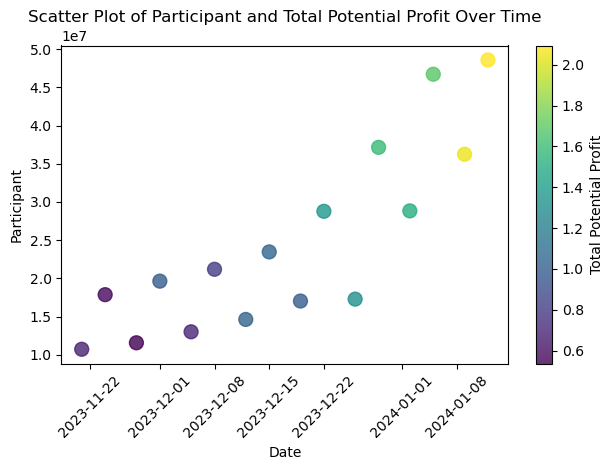

In [123]:
plt.scatter(prediction['Date'], prediction['Participant'], c=prediction['Total Potential Profit'], cmap='viridis', s=100, alpha=0.8)
plt.title('Scatter Plot of Participant and Total Potential Profit Over Time')
plt.xlabel('Date')
plt.ylabel('Participant')
plt.colorbar(label='Total Potential Profit')
plt.xticks(rotation=45)
plt.tight_layout()

Mean Squared Error: 0.037617888616297716


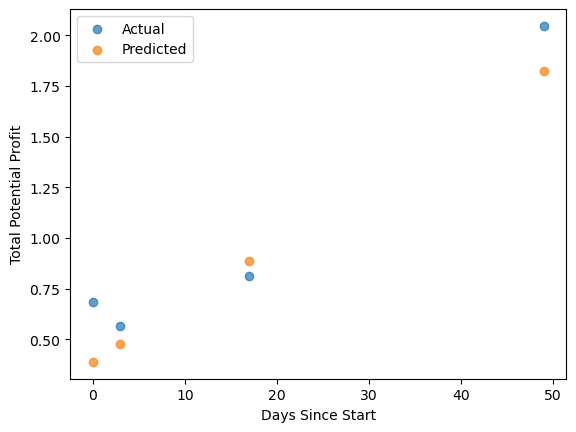

0.8944106154028251

In [152]:
# Convert 'Date' to numeric (days since the start date)
prediction['Date_numeric'] = (prediction['Date'] - prediction['Date'].min()).dt.days

# Split data into features and target
X = prediction[['Date_numeric', 'Participant']]
y = prediction['Total Potential Profit']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit Linear Regression model
model = LinearRegression()
result = model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Plotting predictions vs actual values
plt.scatter(X_test['Date_numeric'], y_test, label='Actual', alpha=0.7)
plt.scatter(X_test['Date_numeric'], y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Days Since Start')
plt.ylabel('Total Potential Profit')
plt.legend()
plt.show()

result.score(X_train, y_train)


In [156]:
# Set the target profit to 3
target_profit = 3.0

# Create a DataFrame with a range of 'Date_numeric' values
days_range = pd.DataFrame({'Date_numeric': range(500)})

# Predict 'Total Potential Profit' for the entire range of dates
predicted_profits = model.predict(days_range[['Date_numeric']])

# Set the target profit to 3
target_profit = 3

# Find the first date where the predicted profit is greater than or equal to 3
estimated_date_index = np.argmax(predicted_profits >= target_profit)

# Get the estimated date
estimated_date = prediction['Date'].min() + pd.to_timedelta(estimated_date_index, unit='D')

print(f"Estimated date to reach a profit of {target_profit}: {estimated_date}")

estimated_date_index


Estimated date to reach a profit of 3: 2024-02-19 00:00:00


90

In [34]:
# calculate potential profit by excluding 5+2
# Exclude '5+2' prize tier
filtered_df = jackpot_df[jackpot_df['Prize Tier'] != '5+2']

# Group by 'Date' and sum the potential profit
total_potential_profit_by_date = filtered_df.groupby('Date')['potential_profit'].sum().reset_index()

# Create a new DataFrame with 'Date' and 'Total Potential Profit' columns
profit_wo_bigreward_df = pd.DataFrame({
    'Date': total_potential_profit_by_date['Date'],
    'Total Potential Profit': total_potential_profit_by_date['potential_profit']
})

print(profit_wo_bigreward_df)

          Date  Total Potential Profit
0   2012-03-23                0.384402
1   2012-03-30                0.272262
2   2012-04-06                0.417329
3   2012-04-13                0.275620
4   2012-04-20                0.519859
..         ...                     ...
706 2023-12-29                0.849489
707 2024-01-02                0.659191
708 2024-01-05                0.822865
709 2024-01-09                1.187470
710 2024-01-12                1.236140

[711 rows x 2 columns]


In [35]:
# Calculate company profit and export data to an Excel file
jackpot_df['Total Prize'] = jackpot_df['Per Winner Prize'] * jackpot_df['Total Winners']
total_prize = jackpot_df.groupby('Date')['Total Prize'].sum().reset_index()

# Create a new DataFrame with 'Date' and 'Total Potential Profit' columns
company_profit_df = pd.DataFrame({
    'Date': total_prize['Date'],
    'Total Prize': total_prize['Total Prize']
})


# Merge with total_reward DataFrame on 'Date' to get 'Total Prize' column
company_profit_df = pd.merge(company_profit_df, total_reward[['Date', 'Total Deposit']], on='Date', how='left')
company_profit_df['Company Profit'] = company_profit_df['Total Deposit'] - company_profit_df['Total Prize']


company_profit_df.to_excel('company profit.xlsx')
company_profit_df.tail(30)

,Date,Total Prize,Total Deposit,Company Profit
681,2023-10-03,6798573.5,2.460488e+07,1.780630e+07
682,2023-10-06,11427588.0,4.149959e+07,3.007201e+07
683,2023-10-10,7730022.4,2.805078e+07,2.032075e+07
684,2023-10-13,0.0,0.000000e+00,0.000000e+00
685,2023-10-17,6210539.8,2.258748e+07,1.637694e+07
686,2023-10-20,10229097.9,3.715604e+07,2.692694e+07
687,2023-10-24,6530772.4,2.365200e+07,1.712123e+07
688,2023-10-27,11063423.9,4.018144e+07,2.911801e+07
689,2023-10-31,0.0,0.000000e+00,0.000000e+00
690,2023-11-03,9831937.5,3.568136e+07,2.584942e+07


In [345]:
grouped_by_date = jackpot_df[jackpot_df['Prize Tier'] == '2+1']

balls_data = grouped_by_date['Balls'].str.split(',')

# Extract main numbers and euro numbers separately
main_numbers = [balls[:5] for balls in balls_data]
euro_numbers = [balls[5:] for balls in balls_data]

# Create new columns for main numbers and euro numbers
grouped_by_date['Main Numbers'] = main_numbers
grouped_by_date['Euro Numbers'] = euro_numbers

# Calculate the frequency of main and euro numbers separately for each date
main_number_frequency = grouped_by_date['Main Numbers'].apply(lambda x: pd.Series([number for main_list in x for number in main_list]).value_counts().sort_index())
euro_number_frequency = grouped_by_date['Euro Numbers'].apply(lambda x: pd.Series([number for euro_list in x for number in euro_list]).value_counts().sort_index())

# Display the frequency
print("Main Number Frequency:")
print(main_number_frequency)

print("\nEuro Number Frequency:")
print(euro_number_frequency)

Main Number Frequency:
        2    3    5    8    9    0    1    4    7    6
11    3.0  2.0  1.0  1.0  1.0  NaN  NaN  NaN  NaN  NaN
23    3.0  1.0  2.0  NaN  NaN  1.0  2.0  1.0  NaN  NaN
35    1.0  3.0  1.0  1.0  1.0  NaN  2.0  NaN  1.0  NaN
47    5.0  1.0  NaN  NaN  NaN  1.0  1.0  1.0  1.0  NaN
59    3.0  2.0  NaN  NaN  NaN  NaN  2.0  1.0  1.0  NaN
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
8483  2.0  2.0  1.0  1.0  1.0  1.0  1.0  NaN  1.0  NaN
8495  NaN  4.0  1.0  NaN  NaN  NaN  1.0  3.0  NaN  NaN
8507  2.0  NaN  NaN  NaN  1.0  NaN  2.0  2.0  1.0  1.0
8519  1.0  2.0  1.0  NaN  NaN  1.0  2.0  2.0  1.0  NaN
8531  1.0  1.0  NaN  1.0  2.0  NaN  1.0  2.0  NaN  2.0

[711 rows x 10 columns]

Euro Number Frequency:
        7    8    4    5    3    6   2    1    9    0
11    1.0  1.0  NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN
23    NaN  1.0  1.0  NaN  NaN  NaN NaN  NaN  NaN  NaN
35    NaN  1.0  NaN  1.0  NaN  NaN NaN  NaN  NaN  NaN
47    NaN  NaN  NaN  1.0  1.0  NaN NaN  NaN  NaN  Na

/var/folders/4v/r9p762h55mn0ttvynz3ppd440000gn/T/ipykernel_85060/3556733992.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_by_date['Main Numbers'] = main_numbers
/var/folders/4v/r9p762h55mn0ttvynz3ppd440000gn/T/ipykernel_85060/3556733992.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_by_date['Euro Numbers'] = euro_numbers
